In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Import packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
import os

#Import Custom Classes
import gym
import gym_combrf

from Source.nn_model_dqn import QNetwork
from Source.dqn_rcv_agent import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average, Generate_BeamDir, All_Exhaustive_RateMeas

## Create channel variation for every location in the environment

In [3]:
#create a channel variation of vectors, one for each location in environment

#create same channel variation over time for all location, as we train MAB separately for every location.
#This can then be compared with DQN with same channel variation over time.

inp_fptr = open("ch_variation_large.txt")
ch_randvals = inp_fptr.read().splitlines()
ch_randvals = [np.complex(a.replace('i','j')) for a in ch_randvals]


## Perform MAB for each location inside the coverage area

In [4]:
import math
mab_env = gym.make('combrf-v5')


def implement_CAB(N, tx_locs, num_actions):
    BeamMap = {}
    Loc_Qvals = [[0]*num_actions for i in range(num_actions*len(tx_locs))]
    Loc_numselections = [[0]*num_actions for i in range(num_actions*len(tx_locs))]
    Loc_maxexhrates =[0 for i in range(num_actions*len(tx_locs))]
    Loc_maxexhselections = [0 for i in range(num_actions*len(tx_locs))]
    train_datarates =[]
    Loc_count = [0 for i in range(num_actions*len(tx_locs))]
        
    #for tbdir_ndx in range(mab_env.N_tx):
    totalrwd = 0
    for loc_ndx in range(len(tx_locs)):
        mab_env = gym.make('combrf-v4')
        tx_loc = tx_locs[loc_ndx]
    #    if(np.all(tx_loc == np.array([[-100,-100,0]]))):
    #           print(tx_loc, loc_ndx)
        #for tbdir_ndx in range(num_actions):
        #mab_env = gym.make('combrf-v4')
        for n in range(N):
            tbdir_ndx = mab_env.action_space.sample()
            #if (n % 50 == 0):
            #mab_env.sc_xyz = eps_scpts[n]
            
            #print("Before: ",Loc_Qvals[loc_ndx*num_actions+tbdir_ndx])
            #rwd, best_action_ndx, datarate, _, Loc_maxexhrates[loc_ndx*num_actions+tbdir_ndx]= (n, num_actions, mab_env, tx_loc,tbdir_ndx, Loc_Qvals[loc_ndx*num_actions+tbdir_ndx], Loc_numselections[loc_ndx*num_actions+tbdir_ndx], Loc_actionsumrates[loc_ndx*num_actions+tbdir_ndx], ch_randvals[n*10:(n+1)*10], Loc_maxexhrates[loc_ndx*num_actions+tbdir_ndx], Loc_maxexhselections[loc_ndx*num_actions+tbdir_ndx])
            totalrwd = 0
            alpha = 0.999
            selected_actions = []
            action_sumrates = [0]*num_actions
            num_selections = [0]*num_actions
            qvals = [[0]*num_actions]

            
            eps_numselections = Loc_numselections[loc_ndx*num_actions+tbdir_ndx]
            eps_Qvals = Loc_Qvals[loc_ndx*num_actions+tbdir_ndx]
            eps_actionsumrates = Loc_actionsumrates[loc_ndx*num_actions+tbdir_ndx]
            prev_maxexhrate = Loc_maxexhrates[loc_ndx*num_actions+tbdir_ndx]
            eps_maxexhselections = Loc_maxexhselections[loc_ndx*num_actions+tbdir_ndx]
            
            #For one CAB episode
            action_ndx = mab_env.reset(tx_loc, tbdir_ndx, ch_randvals[n])
            k = 0
            eps_rwd = 0
            done = False
            while not done:
                max_upperbound = 0
                for i in range(num_actions):
                    if(eps_numselections[i] > 0):
                        avg_rwd = eps_Qvals[i] / eps_numselections[i]
                        delta_i = math.sqrt(2*math.log(n+1+k)/eps_numselections[i])
                        upper_bound = (1-alpha)*avg_rwd + (alpha)*delta_i
                    else:
                        upper_bound = 1e400
                    if upper_bound > max_upperbound:
                        max_upperbound = upper_bound
                        action_ndx = i
                selected_actions.append(action_ndx)
                num_selections[action_ndx] += 1
                eps_numselections[action_ndx] +=1
                rwd, done = mab_env.step(action_ndx, ch_randvals[n+k+1])
                datarate = mab_env.get_rate()
                action_sumrates[action_ndx] += datarate
                eps_actionsumrates[action_ndx] += datarate
                eps_Qvals[action_ndx] += rwd
                eps_rwd += rwd
                k = k+1

            #totalrwd += rwd
            expected_rwdvals = [x/y if (y>0) else 0 for x,y in zip(eps_Qvals,eps_numselections)]
            best_action_ndx = expected_rwdvals.index(max(expected_rwdvals))

            if (eps_numselections[action_ndx] > 0):
                avg_datarate = eps_actionsumrates[best_action_ndx]/eps_numselections[best_action_ndx]
            else:
                avg_datarate = 0
            #if (num_selections[action_ndx] > 0):
            #    expected_rwdvals = [x/y if (y>0) else 0 for x,y in zip(action_sumrates,num_selections)]
            #    best_action_ndx = expected_rwdvals.index(max(expected_rwdvals))
            #    avg_datarate = action_sumrates[best_action_ndx]/num_selections[best_action_ndx]
            #else:
            #    avg_datarate = 0

            min_exhrate, max_exhrate, min_action_ndx, max_action_ndx = mab_env.get_minmax_exhrate(eps_chrandvals)
            new_maxexhrate = (prev_maxexhrate*(eps_maxexhselections-1)+max_exhrate)/(eps_maxexhselections)
            
            Loc_numselections[loc_ndx*num_actions+tbdir_ndx] = eps_numselections
            Loc_Qvals[loc_ndx*num_actions+tbdir_ndx] = eps_Qvals
            Loc_actionsumrates[loc_ndx*num_actions+tbdir_ndx] = eps_actionsumrates
            Loc_maxexhrates[loc_ndx*num_actions+tbdir_ndx] = new_maxexhrate
            
            totalrwd += rwd
            train_datarates.append(avg_datarate)
            #Loc_Qvals.append(Qvals)
            #Loc_numselections.append(num_selections)
            #expected_rwdvals = [ x/y if (y>0) else 0 for x,y in zip(Loc_Qvals[tbdir_ndx],Loc_numselections[tbdir_ndx])]
            #best_action_ndx = expected_rwdvals.index(max(expected_rwdvals))
            BeamMap[str(tx_loc[0][0])+','+ str(tx_loc[0][1]) + ',' +'0'+','+str(tbdir_ndx)] = best_action_ndx

    return BeamMap, Loc_Qvals, Loc_numselections, Loc_maxexhrates, Loc_maxexhselections

N=4100
num_actions = mab_env.action_space.n

tx_locs =[]
for xloc in mab_env.rx_xcov:
    for yloc in mab_env.rx_ycov:
        tx_locs.append(np.array([[xloc, yloc, 0]]))



#learn best beam directions for each TX location using MAB
# Store the learnt beam directions into a dictionary/numpy array
N=4099
num_actions = mab_env.action_space.n

tx_locs =[]
for xloc in mab_env.rx_xcov:
    for yloc in mab_env.rx_ycov:
        tx_locs.append(np.array([[xloc, yloc, 0]]))
#for xloc in mab_env.rx_xcov:
#    for yloc in mab_env.rx_ycov:
#        tx_loc = np.array([[xloc, yloc, 0]])
BeamMap = {}
Loc_Qvals = [[0]*num_actions for i in range(num_actions*len(tx_locs))]
Loc_numselections = [[0]*num_actions for i in range(num_actions*len(tx_locs))]
Loc_actionsumrates = [[0]*num_actions for i in range(num_actions*len(tx_locs))]
Loc_maxexhrates =[0 for i in range(num_actions*len(tx_locs))]
Loc_maxexhselections = [0 for i in range(num_actions*len(tx_locs))]
train_datarates =[]

#for tbdir_ndx in range(mab_env.N_tx):
totalrwd = 0
for n in range(N):
    tbdir_ndx = mab_env.action_space.sample()
    loc_ndx = np.random.randint(0,len(tx_locs))
    tx_loc = tx_locs[loc_ndx] 
    #Qvals = [0]*num_actions
    #num_selections = [0]*num_actions
    Loc_maxexhselections[loc_ndx*num_actions+tbdir_ndx]+=1
    
    rwd, best_action_ndx, datarate, _, Loc_maxexhrates[loc_ndx*num_actions+tbdir_ndx]= implement_CAB(n, num_actions, mab_env, tx_loc,tbdir_ndx, Loc_Qvals[loc_ndx*num_actions+tbdir_ndx], Loc_numselections[loc_ndx*num_actions+tbdir_ndx], Loc_actionsumrates[loc_ndx*num_actions+tbdir_ndx], ch_randvals[n*10:(n+1)*10], Loc_maxexhrates[loc_ndx*num_actions+tbdir_ndx], Loc_maxexhselections[loc_ndx*num_actions+tbdir_ndx])
    totalrwd += rwd
    train_datarates.append(datarate)
    #Loc_Qvals.append(Qvals)
    #Loc_numselections.append(num_selections)
    #expected_rwdvals = [ x/y if (y>0) else 0 for x,y in zip(Loc_Qvals[tbdir_ndx],Loc_numselections[tbdir_ndx])]
    #best_action_ndx = expected_rwdvals.index(max(expected_rwdvals))
    BeamMap[str(tx_loc[0][0])+','+ str(tx_loc[0][1]) + ',' +'0'+','+str(tbdir_ndx)] = best_action_ndx


In [5]:
#CAB for one location using gUCB
def implement_CAB(n, num_actions, env, tx_loc, txbdir_ndx, eps_Qvals, eps_numselections, eps_actionsumrates, eps_chrandvals, prev_maxexhrate, eps_maxexhselections, prev_minexhrate):
    
    totalrwd = 0
    alpha = 0.999
    selected_actions = []
    action_sumrates = [0]*num_actions
    num_selections = [0]*num_actions
    qvals = [[0]*num_actions]
    
    
    #for n in range(N):
    action_ndx = env.reset(tx_loc, tbdir_ndx, eps_chrandvals[0])
    k = 0
    eps_rwd = 0
    done = False
    while not done:
        max_upperbound = 0
        for i in range(num_actions):
            if(eps_numselections[i] > 0):
                avg_rwd = eps_Qvals[i] / eps_numselections[i]
                delta_i = math.sqrt(2*math.log(n+1+k)/eps_numselections[i])
                upper_bound = (1-alpha)*avg_rwd + (alpha)*delta_i
            else:
                upper_bound = 1e400
            if upper_bound > max_upperbound:
                max_upperbound = upper_bound
                action_ndx = i
        selected_actions.append(action_ndx)
        num_selections[action_ndx] += 1
        eps_numselections[action_ndx] +=1
        rwd, done = env.step(action_ndx, eps_chrandvals[k+1])
        datarate = env.get_rate()
        action_sumrates[action_ndx] += datarate
        eps_actionsumrates[action_ndx] += datarate
        eps_Qvals[action_ndx] += rwd
        eps_rwd += rwd
        k = k+1
        
    #totalrwd += rwd
    expected_rwdvals = [x/y if (y>0) else 0 for x,y in zip(eps_Qvals,eps_numselections)]
    best_action_ndx = expected_rwdvals.index(max(expected_rwdvals))
    
    if (eps_numselections[action_ndx] > 0):
        avg_datarate = eps_actionsumrates[best_action_ndx]/eps_numselections[best_action_ndx]
    else:
        avg_datarate = 0
    #if (num_selections[action_ndx] > 0):
    #    expected_rwdvals = [x/y if (y>0) else 0 for x,y in zip(action_sumrates,num_selections)]
    #    best_action_ndx = expected_rwdvals.index(max(expected_rwdvals))
    #    avg_datarate = action_sumrates[best_action_ndx]/num_selections[best_action_ndx]
    #else:
    #    avg_datarate = 0
    
    
    min_exhrate, max_exhrate, min_action_ndx, max_action_ndx = env.get_minmax_exhrate(eps_chrandvals)
    max_exhrate = (prev_maxexhrate*(eps_maxexhselections-1)+max_exhrate)/(eps_maxexhselections)
    min_exhrate = (prev_minexhrate*(eps_maxexhselections-1)+min_exhrate)/(eps_maxexhselections)
    
    return eps_rwd, best_action_ndx, avg_datarate, min_exhrate, max_exhrate

In [6]:
N=4100
num_actions = mab_env.action_space.n

tx_locs =[]
for xloc in mab_env.rx_xcov:
    for yloc in mab_env.rx_ycov:
        tx_locs.append(np.array([[xloc, yloc, 0]]))
        
#for xloc in mab_env.rx_xcov:
#    for yloc in mab_env.rx_ycov:
#        tx_loc = np.array([[xloc, yloc, 0]])
BeamMap = {}
Loc_Qvals = [[0]*num_actions for i in range(num_actions*len(tx_locs))]
Loc_numselections = [[0]*num_actions for i in range(num_actions*len(tx_locs))]
Loc_actionsumrates = [[0]*num_actions for i in range(num_actions*len(tx_locs))]
Loc_maxexhrates =[0 for i in range(num_actions*len(tx_locs))]
Loc_maxexhselections = [0 for i in range(num_actions*len(tx_locs))]
Loc_minexhrates =[0 for i in range(num_actions*len(tx_locs))]

train_datarates =[]
Loc_count = [0 for i in range(num_actions*len(tx_locs))]
        
#for tbdir_ndx in range(mab_env.N_tx):
totalrwd = 0
for loc_ndx in range(len(tx_locs)):
    mab_env = gym.make('combrf-v5')
    tx_loc = tx_locs[loc_ndx]
#    if(np.all(tx_loc == np.array([[-100,-100,0]]))):
#           print(tx_loc, loc_ndx)
    #for tbdir_ndx in range(num_actions):
    for n in range(N):
        tbdir_ndx = mab_env.action_space.sample()
        #if (n % 50 == 0):
        #mab_env.sc_xyz = eps_scpts[n]
        #loc_ndx = np.random.randint(0,len(tx_locs))

        Loc_maxexhselections[loc_ndx*num_actions+tbdir_ndx]+=1
        rwd, best_action_ndx, datarate,Loc_minexhrates[loc_ndx*num_actions+tbdir_ndx], Loc_maxexhrates[loc_ndx*num_actions+tbdir_ndx]= \
        implement_CAB(n, num_actions, mab_env, tx_loc,tbdir_ndx, Loc_Qvals[loc_ndx*num_actions+tbdir_ndx], Loc_numselections[loc_ndx*num_actions+tbdir_ndx], Loc_actionsumrates[loc_ndx*num_actions+tbdir_ndx], ch_randvals[n*11:(n+1)*11], Loc_maxexhrates[loc_ndx*num_actions+tbdir_ndx], Loc_maxexhselections[loc_ndx*num_actions+tbdir_ndx], Loc_minexhrates[loc_ndx*num_actions+tbdir_ndx])
        
        totalrwd += rwd
        train_datarates.append(datarate)
        #Loc_Qvals.append(Qvals)
        #Loc_numselections.append(num_selections)
        #expected_rwdvals = [ x/y if (y>0) else 0 for x,y in zip(Loc_Qvals[tbdir_ndx],Loc_numselections[tbdir_ndx])]
        #best_action_ndx = expected_rwdvals.index(max(expected_rwdvals))
        BeamMap[str(tx_loc[0][0])+','+ str(tx_loc[0][1]) + ',' +'0'+','+str(tbdir_ndx)] = best_action_ndx



In [7]:
#print(BeamMap)
print(tx_locs)
print(len(Loc_Qvals))
print(len(Loc_Qvals[0]))
print(len(Loc_numselections))
print(BeamMap)

[array([[-100, -100,    0]])]
8
8
8
{'-100,-100,0,6': 5, '-100,-100,0,5': 5, '-100,-100,0,0': 5, '-100,-100,0,4': 5, '-100,-100,0,7': 5, '-100,-100,0,2': 5, '-100,-100,0,1': 5, '-100,-100,0,3': 5}


In [21]:
print(Loc_maxexhselections)

[515, 499, 528, 555, 531, 553, 477, 542]


## Learn beamalignment using DQN with channel variation 

In [8]:
#Assume LOS or NLOS throughout the environment. Do not change in between for now

from Source.nn_model_dqn import QNetwork
from Source.dqn_rcv_agent import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average, Generate_BeamDir, All_Exhaustive_RateMeas
from Source.PER import PrioritizedReplayBuffer

#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 128             #minibatch size
GAMMA = 0.999                #discount factor
ALPHA = 1.0                  #non-stationarity parameter
TAU = 1e-3                  #for soft update of target parameters
LR = 5e-4                   #learning rate
TEST_EVERY = 1600            #how often to test the network
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.9985 #125e-6
test_loc = np.array([[100, 100, 0]])
PER_ALPHA = 0.6
PER_BETA = 0.4
PRIORITIZED_REPLAY = False

episodes = 4200 #3100 train, 500 test

test_episodes = 20
seed = 0                    #random seed number
episode_step_limit = 50
#%%
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
#Choose the environment
em = EnvManager(device, 'combrf-v6', seed)
available_actions = em.num_actions_available()
random.seed(seed)
state_size = em.state_size()
print(em.env.ch_model)
print(em.env.sc_xyz)
#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, episodes)

if PRIORITIZED_REPLAY:
    beta_strategy = EpsilonGreedyStrategy(PER_BETA, 1.0, eps_decay, episodes)

#Initialize the agent
agent = Agent(strategy, state_size, available_actions, seed, device)

#Instantiate MemoryBuffer
if not PRIORITIZED_REPLAY:
    memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)
else:
    memory = PrioritizedReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, PER_ALPHA,seed, device)

policy_net = QNetwork(state_size, available_actions, seed).to(device)
target_net = QNetwork(state_size, available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)

uma-los
[]
QNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=4, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=64, bias=True)
  )
  (softmax): Softmax(dim=1)
  (output): Linear(in_features=64, out_features=8, bias=True)
)


#### Test with random untrained actions

In [10]:
obs = em.env.reset(np.exp(1j * 2 * np.pi * 0.6))
print(obs)
ep_rwd=[]
while True:
    action = random.randrange(em.env.action_space.n)
    
    obs, rwd, done, _ = em.env.step(action, np.exp(1j * 2 * np.pi * 0.6))
    print(action)
    ep_rwd.append(rwd)
    if done:
        break
        
print("Episode score: {}".format(np.sum(ep_rwd)))

[[ 0.375  0.125 -0.1   -0.1  ]]
6
6
0
4
7
6
4
7
5
3
Episode score: 5.0


#### Train DQN agent

Episode 4101,	Score: 2.00, eps: 0.01, moving avg_rwd: 5.489999771118164, ep_loss: 1031.14788055419928.983520507812573
test_eps: 4101, eps_rwd: 2.0
TX loc: [[-100 -100    0]]
SC_xyz: []
TX dirs:  [22.500000000000004, 22.500000000000004, 22.500000000000004, 22.500000000000004, 22.500000000000004, 22.500000000000004, 22.500000000000004, 22.500000000000004, 22.500000000000004, 22.500000000000004]
RX dirs:  [135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0]
data rates: [14.666405259224831, 14.494055198382203, 14.31734648000829, 14.142302888905705, 13.977578207126118, 13.83484747580171, 13.727556626817028, 13.668955131729088, 13.668090798284492, 13.728232880180645, 13.841378875763569]
min exh_rate: 4.091450556704648, min_action_ndx: 3
max exh_rate: 7.6190942515238635, max_action_ndx: 5

Episode 4102,	Score: 10.00, eps: 0.01, moving avg_rwd: 5.489999771118164, ep_loss: 967.1861343383789
test_eps: 4102, eps_rwd: 10.0
TX loc: [[-100 -100    0]]
SC_xyz: []
TX dirs:  [45.0, 45

Episode 4114,	Score: 1.00, eps: 0.01, moving avg_rwd: 5.510000228881836, ep_loss: 1008.159782409668
test_eps: 4114, eps_rwd: 1.0
TX loc: [[-100 -100    0]]
SC_xyz: []
TX dirs:  [135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0]
RX dirs:  [157.5, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0]
data rates: [12.433132602150556, 17.837737997855257, 17.79612078233654, 17.74830362649109, 17.693805522009477, 17.633017544005455, 17.565626713631538, 17.49154192962539, 17.41089239757989, 17.32329727978059, 17.228877897670344]
min exh_rate: 3.8450390650001482, min_action_ndx: 3
max exh_rate: 7.396292845263066, max_action_ndx: 5

Episode 4115,	Score: 1.00, eps: 0.01, moving avg_rwd: 5.429999828338623, ep_loss: 970.1976089477539
test_eps: 4115, eps_rwd: 1.0
TX loc: [[-100 -100    0]]
SC_xyz: []
TX dirs:  [157.5, 157.5, 157.5, 157.5, 157.5, 157.5, 157.5, 157.5, 157.5, 157.5]
RX dirs:  [67.5, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0]
data rates:

Episode 4126,	Score: 7.00, eps: 0.01, moving avg_rwd: 5.429999828338623, ep_loss: 987.2379455566406
test_eps: 4126, eps_rwd: 7.0
TX loc: [[-100 -100    0]]
SC_xyz: []
TX dirs:  [45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0]
RX dirs:  [67.5, 157.5, 22.500000000000004, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0]
data rates: [14.555550931603117, 15.44115960482019, 16.663518531558385, 20.979299402098682, 21.014780781001594, 21.040132377627828, 21.05507647883534, 21.0590346571796, 21.051704864443018, 21.032515558463317, 21.00096687641938]
min exh_rate: 5.9217770799089635, min_action_ndx: 3
max exh_rate: 9.058812912686227, max_action_ndx: 5

Episode 4127,	Score: 3.00, eps: 0.01, moving avg_rwd: 5.449999809265137, ep_loss: 1009.180793762207
test_eps: 4127, eps_rwd: 3.0
TX loc: [[-100 -100    0]]
SC_xyz: []
TX dirs:  [67.5, 67.5, 67.5, 67.5, 67.5, 67.5, 67.5, 67.5, 67.5, 67.5]
RX dirs:  [67.5, 157.5, 22.500000000000004, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0]
data r

Episode 4140,	Score: 8.00, eps: 0.01, moving avg_rwd: 5.409999847412109, ep_loss: 1013.1534652709961
test_eps: 4140, eps_rwd: 8.0
TX loc: [[-100 -100    0]]
SC_xyz: []
TX dirs:  [180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
RX dirs:  [157.5, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0]
data rates: [10.82391946984565, 16.32149389934323, 16.37256090699261, 16.415991972502436, 16.45160319093562, 16.479380351321744, 16.49913302396493, 16.510915909801902, 16.51461924121893, 16.510306667071532, 16.49810188459056]
min exh_rate: 3.87935532093321, min_action_ndx: 3
max exh_rate: 7.42388150344365, max_action_ndx: 5

Episode 4141,	Score: 2.00, eps: 0.01, moving avg_rwd: 5.389999866485596, ep_loss: 985.1988067626953
test_eps: 4141, eps_rwd: 2.0
TX loc: [[-100 -100    0]]
SC_xyz: []
TX dirs:  [22.500000000000004, 22.500000000000004, 22.500000000000004, 22.500000000000004, 22.500000000000004, 22.500000000000004, 22.500000000000004, 22.500000000000004, 22.50

Episode 4152,	Score: 2.00, eps: 0.01, moving avg_rwd: 5.519999980926514, ep_loss: 1002.1821670532227
test_eps: 4152, eps_rwd: 2.0
TX loc: [[-100 -100    0]]
SC_xyz: []
TX dirs:  [90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0]
RX dirs:  [112.5, 22.500000000000004, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0]
data rates: [11.736824275131259, 12.012236989653832, 16.268757849119684, 16.24904903710027, 16.223782169514706, 16.192908563480245, 16.15651205718181, 16.11446143678902, 16.066749286590877, 16.01318711235678, 15.953072567853235]
min exh_rate: 2.9962959854101836, min_action_ndx: 3
max exh_rate: 6.476836137804318, max_action_ndx: 5

Episode 4153,	Score: 2.00, eps: 0.01, moving avg_rwd: 5.519999980926514, ep_loss: 1038.138771057129
test_eps: 4153, eps_rwd: 2.0
TX loc: [[-100 -100    0]]
SC_xyz: []
TX dirs:  [112.5, 112.5, 112.5, 112.5, 112.5, 112.5, 112.5, 112.5, 112.5, 112.5]
RX dirs:  [90.0, 22.500000000000004, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 

Episode 4166,	Score: 2.00, eps: 0.01, moving avg_rwd: 5.5, ep_loss: 994.2033996582031
test_eps: 4166, eps_rwd: 2.0
TX loc: [[-100 -100    0]]
SC_xyz: []
TX dirs:  [45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0]
RX dirs:  [90.0, 22.500000000000004, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0]
data rates: [15.549400135402893, 18.82952351800452, 23.03897112534244, 22.97186699472948, 22.89918779727794, 22.820519573920155, 22.735589649661897, 22.644049036977666, 22.54556003381231, 22.43970500863659, 22.326115238078753]
min exh_rate: 5.92975695125649, min_action_ndx: 3
max exh_rate: 9.070729431287102, max_action_ndx: 5

Episode 4167,	Score: 4.00, eps: 0.01, moving avg_rwd: 5.519999980926514, ep_loss: 1045.1097030639648
test_eps: 4167, eps_rwd: 4.0
TX loc: [[-100 -100    0]]
SC_xyz: []
TX dirs:  [67.5, 67.5, 67.5, 67.5, 67.5, 67.5, 67.5, 67.5, 67.5, 67.5]
RX dirs:  [157.5, 22.500000000000004, 135.0, 157.5, 22.500000000000004, 135.0, 135.0, 135.0, 135.0, 135.0]
data rat

Episode 4180,	Score: 1.00, eps: 0.01, moving avg_rwd: 5.510000228881836, ep_loss: 958.2371368408203
test_eps: 4180, eps_rwd: 1.0
TX loc: [[-100 -100    0]]
SC_xyz: []
TX dirs:  [180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
RX dirs:  [157.5, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0]
data rates: [11.132934786754191, 16.496576634052694, 16.421273937805804, 16.34730934291258, 16.275940692924905, 16.208483783549312, 16.14648379833992, 16.091420996980382, 16.044756169518934, 16.007852730525588, 15.98194005153793]
min exh_rate: 3.8841969781662304, min_action_ndx: 3
max exh_rate: 7.432244186108974, max_action_ndx: 5

Episode 4181,	Score: 10.00, eps: 0.01, moving avg_rwd: 5.570000171661377, ep_loss: 908.3153381347656
test_eps: 4181, eps_rwd: 10.0
TX loc: [[-100 -100    0]]
SC_xyz: []
TX dirs:  [22.500000000000004, 22.500000000000004, 22.500000000000004, 22.500000000000004, 22.500000000000004, 22.500000000000004, 22.500000000000004, 22.50000000000000

Episode 4192,	Score: 2.00, eps: 0.01, moving avg_rwd: 5.590000152587891, ep_loss: 1014.1612548828125
test_eps: 4192, eps_rwd: 2.0
TX loc: [[-100 -100    0]]
SC_xyz: []
TX dirs:  [90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0]
RX dirs:  [180.0, 22.500000000000004, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0]
data rates: [9.484274972319058, 10.772323105730445, 15.02257800242609, 15.003446941593602, 14.985312302078327, 14.968169925174271, 14.951944010627114, 14.936571801213825, 14.921572624762764, 14.907212254987497, 14.893489824665854]
min exh_rate: 2.999661625083047, min_action_ndx: 3
max exh_rate: 6.48367936185939, max_action_ndx: 5

Episode 4193,	Score: 0.00, eps: 0.01, moving avg_rwd: 5.5, ep_loss: 1024.148307800293
test_eps: 4193, eps_rwd: 0.0
TX loc: [[-100 -100    0]]
SC_xyz: []
TX dirs:  [112.5, 112.5, 112.5, 112.5, 112.5, 112.5, 112.5, 112.5, 112.5, 112.5]
RX dirs:  [135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0, 135.0]
data rates: [16.224

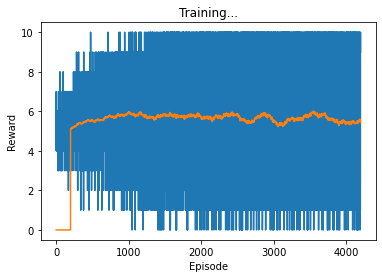

No. of false positives: 0


In [11]:
ep_rewards = []
test_rewards = []
test_data_rates = []
test_eps_iters=[]
test_minexh_rates = []
test_maxexh_rates = []
false_positives =0
policy_net.train()
test_txbdir = 0


outer = tqdm.notebook.tqdm(total=episodes, desc='training loop: ', position=0)
train_steps = 0
for episode in range(episodes):
    
    #if(eps <= 0.1):
    #    em.env.sc_xyz=np.array([])
    #    em.env.ch_model = 'uma-los'
    #if ((episode+1) == 3500):
    #    em.env.ch_model = 'uma-los'
    #    em.env.sc_xyz = np.array([])
        #train_steps = 0
        #strategy =EpsilonGreedyStrategy(1.0, eps_end, 0.997)#0.1
    #if ((episode+1) == 3900):
    #    train_steps=0
    #    strategy =EpsilonGreedyStrategy(1.0, eps_end, 0.9983, 3500)#0.1
    #    if PRIORITIZED_REPLAY:
    #        beta_strategy = EpsilonGreedyStrategy(PER_BETA, 1.0, eps_decay, 3500)
    #em.env.sc_xyz = eps_scpts[episode]
    if ((episode+1) > 4100):    
        obs = em.test_reset(np.array([[-100,-100,0]]), test_txbdir, em.env.sc_xyz, ch_randvals[episode*(em.env.goal_steps+1)])
        test_txbdir = (test_txbdir + 1) % em.env.N_tx
    else:
        #tx_loc_xndx, tx_loc_yndx, tx_dir_ndx =em.env.obs_space.sample()
        obs = em.reset(ch_randvals[episode*(em.env.goal_steps+1)])
        #obs = em.test_reset(np.array([[em.env.rx_xcov[tx_loc_xndx],em.env.rx_ycov[tx_loc_yndx], 0]]), tx_dir_ndx, em.env.sc_xyz, ch_randvals[episode*(em.env.goal_steps+1)])
        #dqnloc_maxexhselections[(tx_loc_xndx*len(em.env.rx_ycov)+tx_loc_yndx)*available_actions+tx_dir_ndx]+=1
    
    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    tx_dirs = []
    rx_dirs = []
    data_rates =[]
    #agent.current_step +=1
    train_steps +=1
    eps = strategy.get_exploration_rate(train_steps)
    if PRIORITIZED_REPLAY:
        beta = beta_strategy.get_exploration_rate(train_steps)
    
    while True:
        tx_dirs.append(em.env.tx_bdir*(180/np.pi))
        rx_dirs.append(em.env.rx_bdir*(180/np.pi))
        data_rates.append(em.env.rate)

        action = agent.act(obs, policy_net, eps)
        next_obs, reward, done, _ = em.step(action,ch_randvals[episode*(em.env.goal_steps+1)+timestep+1])
        #agent.step(obs, action, reward, next_obs, done)
        ep_rwd += reward.item()
        
        '''
        if(np.all(em.env.tx_loc == np.array([[100,100,0]]))):
            print("ch_model: {}, sc_xyz: {}, min_exh_rate: {}, max_exh_rate: {}, min_action_ndx: {}, max_action_ndx: {}".format(em.env.ch_model, em.env.sc_xyz, min_exh_rate, max_exh_rate, min_action_ndx, max_action_ndx))
        '''   
        memory.add(obs, action, reward, next_obs, done)
        obs = next_obs
        
        if memory.can_provide_sample():
            
            if PRIORITIZED_REPLAY:
                experiences = memory.sample(beta)
                observations, actions, rewards, next_observations, dones, weights, batch_indices = experiences
            else:
                experiences = memory.sample()
                observations, actions, rewards, next_observations, dones = experiences
                weights, batch_indices = torch.tensor(np.ones_like(rewards.cpu().data.numpy())).to(device), None
            
            #print(states.shape, states.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))#(1-ALPHA)*
            
            next_q_values = target_net(next_observations).detach().max(1)[0]
            target_q_values = ((next_q_values*GAMMA) + rewards)
            #print(policy_net(observations).type())
            #print(target_q_values.unsqueeze(1).type())
            #loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float())
            td_errors = ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values)
            loss = F.mse_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction=None)
            #weighted_loss = torch.mean(weights*loss)
            #print("loss: ", loss)
            #loss = ALPHA*loss
            #ep_loss += weighted_loss.item()
            ep_loss += loss.item()
            
            optimizer.zero_grad()
            #weighted_loss.backward()
            loss.backward()
            optimizer.step()
            
            if PRIORITIZED_REPLAY:
                comp_errors = np.array([x[0] for x in td_errors.cpu().data.numpy()])
                new_priorities = np.abs(comp_errors) + 1e-6
                #print(new_priorities)
                memory.update_priorities(batch_indices.cpu().data.numpy(), new_priorities)
            
        timestep +=1
        if done:
            data_rates.append(em.env.rate)
            ep_rewards.append(ep_rwd)
            moving_avg_rwd = get_moving_average(100, ep_rewards)
            print('\rEpisode {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}, ep_loss: {}'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], ep_loss), end="\r")
            #plot(episode_rewards, 100)
            min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx= em.env.get_minmax_exhrate(ch_randvals[episode*(em.env.goal_steps+1):(episode+1)*(em.env.goal_steps+1)])
            
            #if(((episode+1) >= 6000) or (3000 <= (episode+1)<=3500)):
            if((episode+1) > 4100):
                
                test_data_rates.append(np.mean(data_rates[1:]))
                test_eps_iters.append(timestep)
                test_minexh_rates.append(min_exh_rate)
                test_maxexh_rates.append(max_exh_rate)
                
                #if (timestep > 3):
                #    if(timestep >=8):
                #        false_positives +=1
                #if (min_exh_rate == max_exh_rate):
                print("\ntest_eps: {0}, eps_rwd: {1}".format(episode+1, ep_rwd))
                print("TX loc: {}".format(em.env.tx_loc))
                print("SC_xyz: {}".format(em.env.sc_xyz))
                print("TX dirs: ", tx_dirs)
                print("RX dirs: ", rx_dirs)
                print("data rates: {}".format(data_rates))
                print("min exh_rate: {}, min_action_ndx: {}".format(min_exh_rate, min_action_ndx))
                print("max exh_rate: {}, max_action_ndx: {}\n".format(max_exh_rate, max_action_ndx))
                
            timestep = 0
            break
            
    for local_param, target_param in zip(policy_net.parameters(), target_net.parameters()):
        target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)
    
    # update tqdm bar
    outer.update(1)
    
torch.save(policy_net.state_dict(), 'checkpoint.pth')

#timer.finish()
plot(ep_rewards, 200, test_rewards)
print("No. of false positives: {}".format(false_positives))

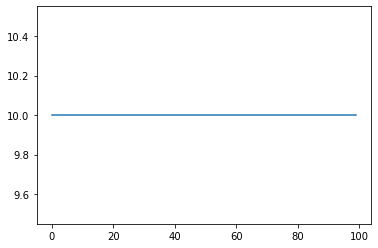

10.0 100


In [12]:
fig=plt.figure()
min_ndx=0
max_ndx=500
plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.show()
print(np.mean(test_eps_iters), len(test_eps_iters))

In [20]:
print(em.env.ch_model)
print(em.env.sc_xyz)
print(em.env.dqnloc_maxexhselections)
print(em.env.dqnloc_maxexhrates)
print(em.env.dqnloc_minexhrates)

uma-los
[]
[5599, 5742, 5764, 5941, 5654, 5962, 5742, 5808]
[7.638701827104834, 9.078472693695979, 8.13010849994191, 6.485215720873547, 6.911874169807371, 7.411739903005634, 7.929883840533956, 7.4354811791189315]
[4.102234419588744, 5.934382116134497, 4.581022226858282, 3.0005048482901744, 3.381872835558821, 3.8536392452196835, 4.3856703501845535, 3.8860358462372107]


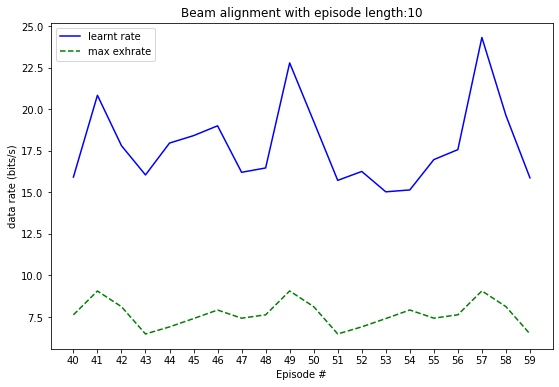

In [14]:
fig = plt.figure(figsize=[9, 6])
min_ndx=40
max_ndx=60
#plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_minexh_rates[min_ndx:max_ndx], 'r--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--')
plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--')
#plt.plot(np.arange(len(test_data_rates[3080:3140])), test_data_rates[3080:3140], 'b', np.arange(len(test_data_rates[3080:3140])), test_minexh_rates[3080:3140], 'r--', np.arange(len(test_data_rates[3080:3140])), test_maxexh_rates[3080:3140],'g--')
#plt.plot(np.arange(len(test_data_rates[4650:4740])), test_data_rates[4650:4740], 'b', np.arange(len(test_data_rates[4650:4740])), test_minexh_rates[4650:4740], 'r--', np.arange(len(test_data_rates[4650:4740])), test_maxexh_rates[4650:4740],'g--')
#plt.plot(np.arange(len(test_data_rates[6230:])), test_data_rates[6230:], 'b', np.arange(len(test_data_rates[6230:])), test_minexh_rates[6230:], 'r--', np.arange(len(test_data_rates[6230:])), test_maxexh_rates[6230:],'g--')

plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
#plt.legend(['learnt rate','min exhrate', 'max exhrate'])
plt.legend(['learnt rate','max exhrate'])
plt.xlabel('Episode #')
plt.ylabel('data rate (bits/s)')
plt.title('Beam alignment with episode length:{}'.format(em.env.goal_steps))
plt.show()

## Simulation 2: BeamAlignment over location CAB vs DQN for fast fading

In [15]:
#Apply same channel values to BeamMap and DQN
N_iter = 100
selected_chvals = ch_randvals[4100:4100+N_iter*11]
selected_loc = np.array([[-100,-100,0]])
mabtest_datarates = []
mabtestmin_exhrates =[]
mabtestmax_exhrates =[]
#Task1: Update MAB BeamMap with selected channelvals
break_flag = False
loc_ndx = 0
for xloc in mab_env.rx_xcov:
    for yloc in mab_env.rx_ycov:
        tx_loc = np.array([[xloc, yloc, 0]])
        if (np.all(tx_loc == selected_loc)):
            break_flag = True
            break
        if break_flag:
            break
        loc_ndx = loc_ndx +1
            
tbdir_ndx = 0            
for i in range(N_iter):    
    print("tbdir_ndx: {}, loc_ndx: {}".format(tbdir_ndx, loc_ndx))
    #Qvals = Loc_Qvals[loc_ndx+tbdir_ndx]
    #num_selections = Loc_numselections[loc_ndx+tbdir_ndx]
    Loc_maxexhselections[loc_ndx*num_actions+tbdir_ndx]+=1
    totalrwd, best_action_ndx, datarate, min_exhrate, max_exhrate= \
    implement_CAB(i, num_actions, mab_env, selected_loc, tbdir_ndx, Loc_Qvals[loc_ndx*num_actions+tbdir_ndx], Loc_numselections[loc_ndx*num_actions+tbdir_ndx], Loc_actionsumrates[loc_ndx*num_actions+tbdir_ndx], selected_chvals[i*11:(i+1)*11], Loc_maxexhrates[loc_ndx*num_actions+tbdir_ndx], Loc_maxexhselections[loc_ndx*num_actions+tbdir_ndx], Loc_minexhrates[loc_ndx*num_actions+tbdir_ndx])
    Loc_maxexhrates[loc_ndx*num_actions+tbdir_ndx] = max_exhrate
    Loc_minexhrates[loc_ndx*num_actions+tbdir_ndx] = min_exhrate
    #Loc_Qvals[loc_ndx+tbdir_ndx]= Qvals
    #Loc_numselections[loc_ndx+tbdir_ndx]=num_selections
    
    mabtest_datarates.append(datarate)
    mabtestmin_exhrates.append(min_exhrate)
    mabtestmax_exhrates.append(max_exhrate)
    
    BeamMap[str(selected_loc[0][0])+','+ str(selected_loc[0][1]) + ',' +'0'+','+str(tbdir_ndx)] = best_action_ndx
    tbdir_ndx = (tbdir_ndx +1) % 8


for tbdir_ndx in range(mab_env.N_tx):
    print('loc: {}, tbdir_ndx: {}, best_action_ndx: {}'.format(selected_loc, tbdir_ndx, BeamMap[str(selected_loc[0][0])+','+ str(selected_loc[0][1]) + ',' +'0'+','+str(tbdir_ndx)]))

tbdir_ndx: 0, loc_ndx: 0
tbdir_ndx: 1, loc_ndx: 0
tbdir_ndx: 2, loc_ndx: 0
tbdir_ndx: 3, loc_ndx: 0
tbdir_ndx: 4, loc_ndx: 0
tbdir_ndx: 5, loc_ndx: 0
tbdir_ndx: 6, loc_ndx: 0
tbdir_ndx: 7, loc_ndx: 0
tbdir_ndx: 0, loc_ndx: 0
tbdir_ndx: 1, loc_ndx: 0
tbdir_ndx: 2, loc_ndx: 0
tbdir_ndx: 3, loc_ndx: 0
tbdir_ndx: 4, loc_ndx: 0
tbdir_ndx: 5, loc_ndx: 0
tbdir_ndx: 6, loc_ndx: 0
tbdir_ndx: 7, loc_ndx: 0
tbdir_ndx: 0, loc_ndx: 0
tbdir_ndx: 1, loc_ndx: 0
tbdir_ndx: 2, loc_ndx: 0
tbdir_ndx: 3, loc_ndx: 0
tbdir_ndx: 4, loc_ndx: 0
tbdir_ndx: 5, loc_ndx: 0
tbdir_ndx: 6, loc_ndx: 0
tbdir_ndx: 7, loc_ndx: 0
tbdir_ndx: 0, loc_ndx: 0
tbdir_ndx: 1, loc_ndx: 0
tbdir_ndx: 2, loc_ndx: 0
tbdir_ndx: 3, loc_ndx: 0
tbdir_ndx: 4, loc_ndx: 0
tbdir_ndx: 5, loc_ndx: 0
tbdir_ndx: 6, loc_ndx: 0
tbdir_ndx: 7, loc_ndx: 0
tbdir_ndx: 0, loc_ndx: 0
tbdir_ndx: 1, loc_ndx: 0
tbdir_ndx: 2, loc_ndx: 0
tbdir_ndx: 3, loc_ndx: 0
tbdir_ndx: 4, loc_ndx: 0
tbdir_ndx: 5, loc_ndx: 0
tbdir_ndx: 6, loc_ndx: 0
tbdir_ndx: 7, loc_ndx: 0


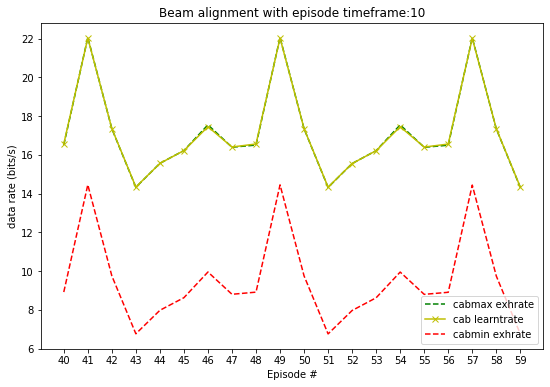

In [16]:
fig = plt.figure(figsize=[9, 6])
min_ndx=40
max_ndx=60
#plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b.-', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_minexh_rates[min_ndx:max_ndx], 'r--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--', np.arange(len(test_data_rates[min_ndx:max_ndx])), mabtest_datarates[min_ndx:max_ndx], 'yx-')
plt.plot(np.arange(len(mabtestmax_exhrates[min_ndx:max_ndx])), mabtestmax_exhrates[min_ndx:max_ndx], 'g--', np.arange(len(mabtestmax_exhrates[min_ndx:max_ndx])), mabtest_datarates[min_ndx:max_ndx], 'yx-',  np.arange(len(mabtestmax_exhrates[min_ndx:max_ndx])), mabtestmin_exhrates[min_ndx:max_ndx], 'r--')
#plt.plot(np.arange(len(test_data_rates[3080:3140])), test_data_rates[3080:3140], 'b', np.arange(len(test_data_rates[3080:3140])), test_minexh_rates[3080:3140], 'r--', np.arange(len(test_data_rates[3080:3140])), test_maxexh_rates[3080:3140],'g--')
#plt.plot(np.arange(len(test_data_rates[4650:4740])), test_data_rates[4650:4740], 'b', np.arange(len(test_data_rates[4650:4740])), test_minexh_rates[4650:4740], 'r--', np.arange(len(test_data_rates[4650:4740])), test_maxexh_rates[4650:4740],'g--')
#plt.plot(np.arange(len(test_data_rates[6230:])), test_data_rates[6230:], 'b', np.arange(len(test_data_rates[6230:])), test_minexh_rates[6230:], 'r--', np.arange(len(test_data_rates[6230:])), test_maxexh_rates[6230:],'g--')
plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
#plt.legend(['dqn learntrate','min exhrate', 'max exhrate', 'mab learntrate'])
plt.legend(['cabmax exhrate', 'cab learntrate', 'cabmin exhrate'])
plt.xlabel('Episode #')
plt.ylabel('data rate (bits/s)')
plt.title('Beam alignment with episode timeframe:{}'.format(mab_env.episode_time))
plt.show()

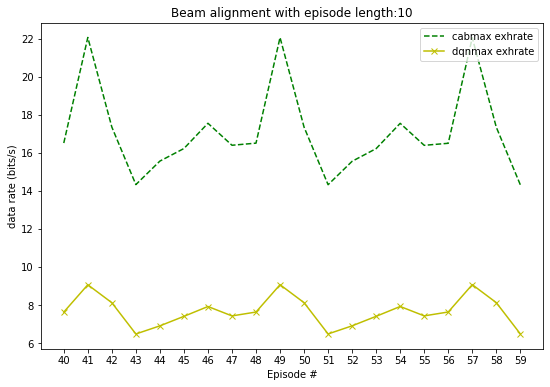

In [17]:
fig = plt.figure(figsize=[9, 6])
min_ndx=40
max_ndx=60
#plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b.-', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_minexh_rates[min_ndx:max_ndx], 'r--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--', np.arange(len(test_data_rates[min_ndx:max_ndx])), mabtest_datarates[min_ndx:max_ndx], 'yx-')
plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), mabtestmax_exhrates[min_ndx:max_ndx], 'g--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'yx-')
#plt.plot(np.arange(len(test_data_rates[3080:3140])), test_data_rates[3080:3140], 'b', np.arange(len(test_data_rates[3080:3140])), test_minexh_rates[3080:3140], 'r--', np.arange(len(test_data_rates[3080:3140])), test_maxexh_rates[3080:3140],'g--')
#plt.plot(np.arange(len(test_data_rates[4650:4740])), test_data_rates[4650:4740], 'b', np.arange(len(test_data_rates[4650:4740])), test_minexh_rates[4650:4740], 'r--', np.arange(len(test_data_rates[4650:4740])), test_maxexh_rates[4650:4740],'g--')
#plt.plot(np.arange(len(test_data_rates[6230:])), test_data_rates[6230:], 'b', np.arange(len(test_data_rates[6230:])), test_minexh_rates[6230:], 'r--', np.arange(len(test_data_rates[6230:])), test_maxexh_rates[6230:],'g--')
plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
#plt.legend(['dqn learntrate','min exhrate', 'max exhrate', 'mab learntrate'])
plt.legend(['cabmax exhrate', 'dqnmax exhrate'])
plt.xlabel('Episode #')
plt.ylabel('data rate (bits/s)')
plt.title('Beam alignment with episode length:{}'.format(em.env.goal_steps))
plt.show()

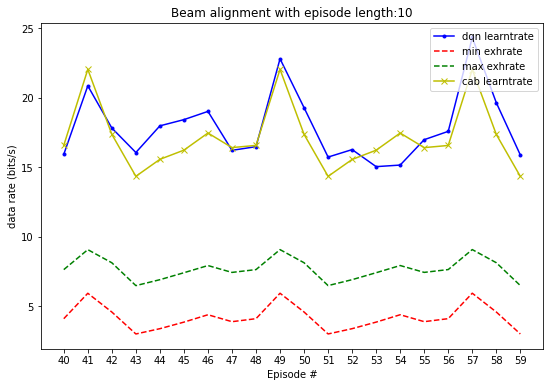

In [18]:
fig = plt.figure(figsize=[9, 6])
min_ndx=40
max_ndx=60
plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b.-', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_minexh_rates[min_ndx:max_ndx], 'r--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--', np.arange(len(test_data_rates[min_ndx:max_ndx])), mabtest_datarates[min_ndx:max_ndx], 'yx-')
#plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), mabtestmax_exhrates[min_ndx:max_ndx], 'g--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'yx-')
#plt.plot(np.arange(len(test_data_rates[3080:3140])), test_data_rates[3080:3140], 'b', np.arange(len(test_data_rates[3080:3140])), test_minexh_rates[3080:3140], 'r--', np.arange(len(test_data_rates[3080:3140])), test_maxexh_rates[3080:3140],'g--')
#plt.plot(np.arange(len(test_data_rates[4650:4740])), test_data_rates[4650:4740], 'b', np.arange(len(test_data_rates[4650:4740])), test_minexh_rates[4650:4740], 'r--', np.arange(len(test_data_rates[4650:4740])), test_maxexh_rates[4650:4740],'g--')
#plt.plot(np.arange(len(test_data_rates[6230:])), test_data_rates[6230:], 'b', np.arange(len(test_data_rates[6230:])), test_minexh_rates[6230:], 'r--', np.arange(len(test_data_rates[6230:])), test_maxexh_rates[6230:],'g--')
plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
plt.legend(['dqn learntrate','min exhrate', 'max exhrate', 'cab learntrate'])
#plt.legend(['max exhrate', 'mab learntrate'])
plt.xlabel('Episode #')
plt.ylabel('data rate (bits/s)')
plt.title('Beam alignment with episode length:{}'.format(em.env.goal_steps))
plt.show()

## Simulation 1: Beamalignment with channel variation in online manner